In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from raps.raps import lower_bound
import matplotlib.pyplot as plt
import matplotlib as mplt
import numpy as np
from tqdm.auto import trange
from u4ml.plot import plot_mean_std, LinesPlotter

from pickle import dump, load
from random import choice
from tqdm.auto import tqdm
from raps.raps import (find_target, make_erdos_renyi,
                       iter_ancestors, iter_descendants,
                       find_all_targets)
from raps.exp import MultiParentNumInterventionsExp
from u4ml.plot import MeansPlotter, extend_line, refresh_axis

plt.rcParams.update({'font.size': 24})

### Erdös-Rényi Model

#### Fast Regime

In [3]:
ns = np.logspace(0, 10, base=2, num=11).astype(int)

Output()

  0%|          | 0/20 [00:00<?, ?it/s]

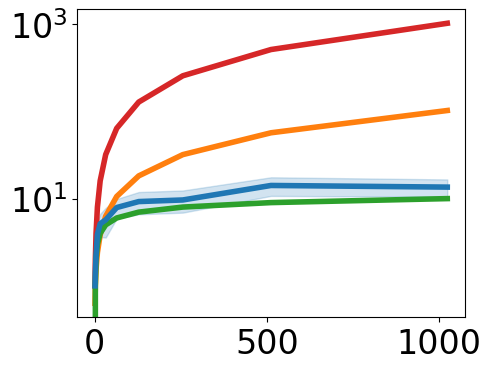

In [4]:
er_fast_fig = plt.figure(figsize=(5, 4))
plt.semilogy()

plt.plot(ns, ns, label="linear", color="C3", lw=2)
plt.plot(ns, ns / np.log2(ns + 2), label="$n/\log_2(n)$", 
         color="C1", lw=2)
plt.plot(ns, np.log2(ns), label="$log_2(n)$", color="C2", lw=2)

with MeansPlotter.make_autoclear_context() as er_fast_plotter:
  for line in plt.gca().lines:
    er_fast_plotter.lines[line.get_label()].append(line)
    
  for i in trange(20):
    for n in ns:
      logn = max(2, np.log2(n))
      adj = make_erdos_renyi(n, 1 - (0.5 / (logn - 1)) ** (1 / (logn - 1)))
      num_interventions = find_target(adj, choice(list(range(n))))
      er_fast_plotter.extend("experiment", [n], [num_interventions], 
                             redraw_legend=False)
    er_fast_plotter.means(linewidth=4, alpha=0.2, redraw_legend=False)

In [5]:
er_fast_fig.axes[0].set_ylabel("No. interventions")
er_fast_fig.axes[0].set_xlabel("$n$");

In [6]:
def annotate(fig, positions):
  annotations = []
  handels_labels = fig.axes[0].get_legend_handles_labels()
  for i, (hndl, lbl) in enumerate(zip(*handels_labels)):
    ann = fig.axes[0].annotate(lbl, xy=positions[i],
                               color=hndl.get_color(),
                               fontsize=26)
    annotations.append(ann)
  return annotations

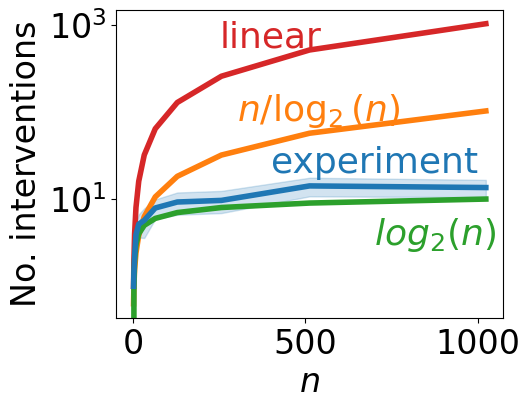

In [7]:
annotate(er_fast_fig, [(250, 550), (300, 80), (700, 3), (400, 20)]);
er_fast_fig

In [8]:
er_fast_fig.savefig("graphics/erdos-renyi-fast.pdf", dpi=1200, 
                    format="pdf", bbox_inches=0)

#### Slow Regime

Output()

  0%|          | 0/20 [00:00<?, ?it/s]

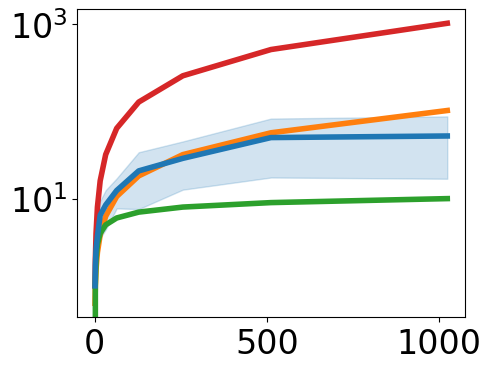

In [9]:
er_slow_fig = plt.figure(figsize=(5, 4))
plt.semilogy()

plt.plot(ns, ns, label="linear", color="C3", lw=2)
plt.plot(ns, ns / np.log2(ns + 2), label="$n/log_2(n)$", 
         color="C1", lw=2)
plt.plot(ns, np.log2(ns), label="$log_2(n)$", 
         color="C2", lw=2)

with MeansPlotter.make_autoclear_context() as er_slow_plotter:
  for line in plt.gca().lines:
    er_slow_plotter.lines[line.get_label()].append(line)
  
  for i in trange(20):
    for n in ns:
      adj = make_erdos_renyi(n, np.log(n) / n)
      num_interventions = find_target(adj, choice(list(range(n))))
      er_slow_plotter.extend("experiment", [n], [num_interventions],
                             redraw_legend=False)
    er_slow_plotter.means(linewidth=4, alpha=0.2, redraw_legend=False)

In [10]:
er_slow_fig.axes[0].set_ylabel("No. interventions")
er_slow_fig.axes[0].set_xlabel("$n$");

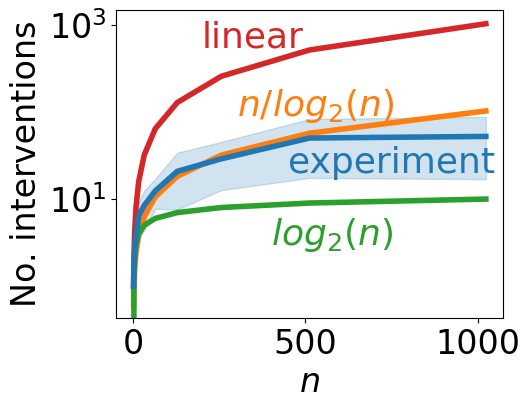

In [11]:
annotations = annotate(er_slow_fig, [(200, 550), (300, 90), (400, 3), (450, 20)])
er_slow_fig

In [12]:
er_slow_fig.savefig("graphics/erdos-renyi-slow.pdf", dpi=1200,
                    format="pdf", bbox_inches="tight")

### Exact Equation for the Expected Number of Parents

Output()

  0%|          | 0/11 [00:00<?, ?it/s]

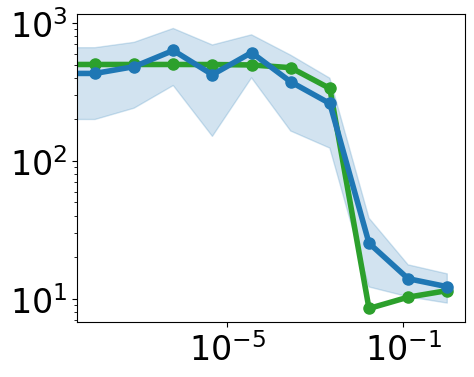

In [13]:
ps = [0] + list(np.logspace(-8, 0, num=10, base=10))
n = 1000

exact_fig = plt.figure(figsize=(5, 4))
plt.loglog()


with MeansPlotter.make_autoclear_context() as exact_plotter:
  exact_plotter.lines["Eq. 2"].append(plt.plot([], [], label="Eq. 2",
                                               color="C2")[0])
  for i in range(20):
    exact_plotter.lines["experiment"].append(
        plt.plot([], [], label="experiment", color="C0")[0])
  
  for p in tqdm(ps):
    adj = make_erdos_renyi(n, p)
    target = choice(list(range(n)))
    extend_line(exact_plotter.lines["Eq. 2"][0],
                [p], [lower_bound(adj, target)])
    
    for i in range(20):
      num_interventions = find_target(adj, target)
      extend_line(exact_plotter.lines["experiment"][i],
                  [p], [num_interventions])
      
    exact_plotter.lines_plotter.before_extend_line()
    exact_plotter.means(linewidth=4, alpha=0.2, marker='o',
                        markersize=8)
    exact_plotter.lines_plotter.after_extend_line()

In [14]:
exact_fig.axes[0].set_xlabel("$p$")
exact_fig.axes[0].set_ylabel("No. interventions");

In [15]:
exact_fig.axes[0].legend(bbox_to_anchor=(0.7, 0.38));

In [16]:
for item in exact_fig.axes[0].get_legend().get_texts():
  item.set_fontsize(16)

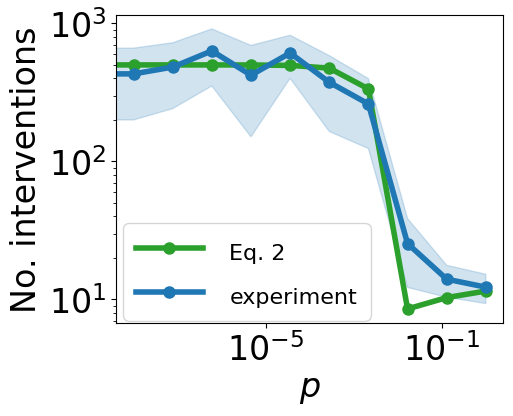

In [17]:
exact_fig

In [18]:
exact_fig.savefig("graphics/exact.pdf", dpi=1200,
                  format="pdf", bbox_inches="tight")

## Multiparent

Output()

  0%|          | 0/20 [00:00<?, ?it/s]

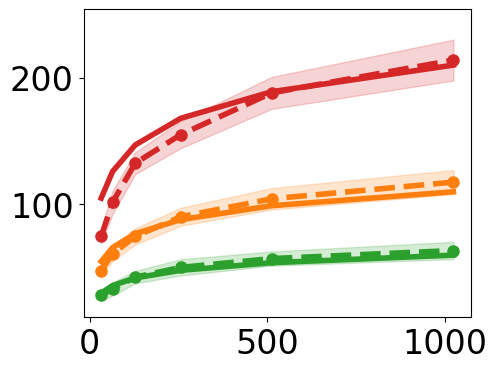

In [19]:
ns = np.logspace(5, 10, base=2, num=6).astype(int)
num_parents = [5, 10, 20]

multiparent_fig = plt.figure(figsize=(5, 4))
exp = MultiParentNumInterventionsExp(ns, num_parents)
    
with MeansPlotter.make_autoclear_context() as multiparent_plotter:
  exp.initialize_colors(multiparent_plotter.lines_plotter,
                        linestyle="dashed")
  for _ in trange(20):
    exp.run(multiparent_plotter)
    multiparent_plotter.means(linestyle="dashed", marker='o',
                              linewidth=4, alpha=0.2, markersize=8,
                              redraw_legend=False)
    exp.plot_bounds()

In [20]:
multiparent_fig.axes[0].set_xlabel(rf"$n$")
multiparent_fig.axes[0].set_ylabel("No. interventions");

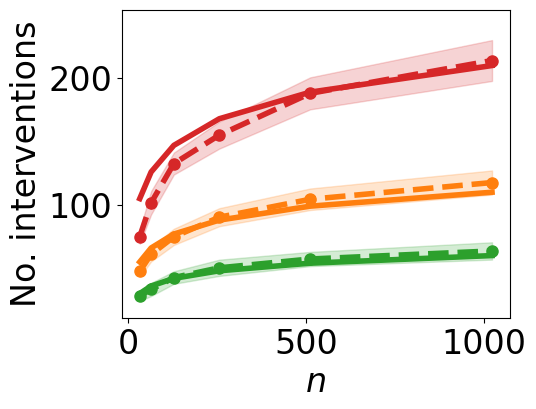

In [21]:
multiparent_fig

In [22]:
multiparent_fig.savefig("graphics/multiparent.pdf", 
                        dpi=1200, bbox_inches="tight",
                        format="pdf")

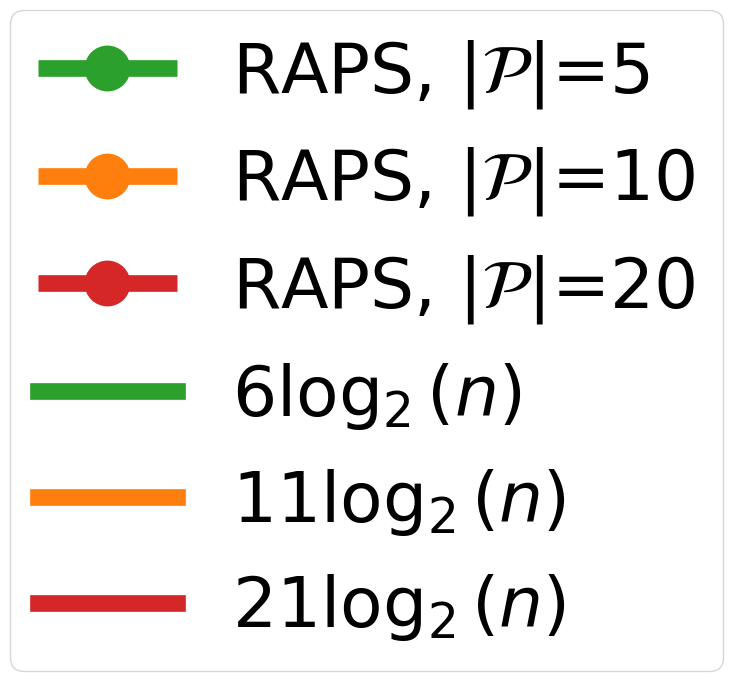

In [24]:
label_params = multiparent_fig.axes[0].get_legend_handles_labels() 

fig, ax = plt.subplots()
ax.axis(False)
legend = ax.legend(*label_params, loc="center", 
                   bbox_to_anchor=(0.5, 0.5), prop={"size":50})
for legend_line in legend.legend_handles:
  legend_line.set_linewidth(12)
  legend_line.set_markersize(32)
fig.savefig("graphics/multiparent-legend.pdf", dpi=1200,
            format="pdf", bbox_inches="tight")